In [2]:
# coding: utf-8

# In[7]:

import sys,os
import numpy as np
import dicom
import glob
import matplotlib
# matplotlib.use('Agg')
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import time
from sklearn import cross_validation
from lightgbm.sklearn import LGBMRegressor
from Vgg19 import VGG19
#from resnet50 import ResNet50
from keras.preprocessing import image
#from imagenet_utils import preprocess_input
#from PIL import Image
#from resizeimage import resizeimage

In [13]:
import errno
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise
EXPERIMENT_NUMBER = 'vgg19' 

#Put here the path where you downloaded all kaggle data
DATA_PATH='data/'

# Path and variables
STAGE1_LABELS=DATA_PATH + 'stage1_labels.csv'
STAGE1_SAMPLE_SUBMISSION=DATA_PATH + 'stage1_sample_submission.csv'
STAGE1_FOLDER=DATA_PATH + 'stage1/'
FEATURE_FOLDER=DATA_PATH + 'features/features' + EXPERIMENT_NUMBER + '/'
SUBMIT_OUTPUT='submit' + EXPERIMENT_NUMBER + '.csv'

make_sure_path_exists(FEATURE_FOLDER)

In [4]:
# Timer class
class Timer(object):
    def __enter__(self):
        self.start()
        return self

    def __exit__(self, *args):
        self.stop()

    def start(self):
        self.start = time.clock()

    def stop(self):
        self.end = time.clock()
        self.interval = self.end - self.start


In [5]:
def get_3d_data(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return np.stack([s.pixel_array for s in slices])

In [6]:
def get_data_id(path, plot_data=False):
    sample_image = get_3d_data(path)
    sample_image[sample_image == -2000] = 0
    #if plot_data:
    #    f, plots = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(10, 8))

    batch = []
    cnt = 0
    dx = 40
    ds = 512
    for i in range(0, sample_image.shape[0] - 3, 3):
        tmp = []
        for j in range(3):
            img = sample_image[i + j]
            img = 255.0 / np.amax(img) * img
            img = cv2.equalizeHist(img.astype(np.uint8))
            img = img.astype(np.uint8)
            img = img[dx: ds - dx, dx: ds - dx]
            img = cv2.resize(img, (224, 224))
            #img = resizeimage.resize_crop(img, [224, 224])
            #img = np.resize(img, (224,224))
            tmp.append(img)

        tmp = np.array(tmp)
        tmp = np.swapaxes(tmp,0,2) #we need to make "color" dimension last I think
        batch.append(np.array(tmp))

#         if plot_data:
#             if cnt < 20:
#                 plots[cnt // 5, cnt % 5].axis('off')
#                 plots[cnt // 5, cnt % 5].imshow(tmp[0,:,:], cmap='gray')
#             cnt += 1

#     if plot_data: plt.show()
        
    batch = np.array(batch, dtype='int')
    return batch



In [7]:
def get_model():
    model = VGG19(weights='imagenet', include_top=False)
    return model

In [8]:
def calc_features(verbose=False):
    model = get_model()
    for folder in glob.glob(STAGE1_FOLDER+'*'):
        foldername = os.path.basename(folder)
        if os.path.isfile(FEATURE_FOLDER+foldername+'.npy'):
            if verbose: print("Features in %s already computed" % (FEATURE_FOLDER+foldername))
            continue
        batch = get_data_id(folder)
        if verbose:
            print("Batch size:")
            print(batch.shape)
        feats = model.predict(batch, batch_size=52, verbose=1)

        if verbose:
            print(feats.shape)
            print("Saving features in %s" % (FEATURE_FOLDER+foldername))
        np.save(FEATURE_FOLDER+foldername, feats)

In [17]:
        
#%%time
# Calculate features
calc_features(verbose=False)

InternalError: Dst tensor is not initialized.
	 [[Node: _recv_input_3_0/_393 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_126__recv_input_3_0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: block5_pool_2/MaxPool/_395 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_51_block5_pool_2/MaxPool", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

In [14]:
# In[25]:

def train_lightgbm():
    df = pd.read_csv(STAGE1_LABELS)

    x = np.array([np.mean(np.load(FEATURE_FOLDER+'%s.npy' % str(id)), axis=0).flatten() for id in df['id'].tolist()])
    y = df['cancer'].as_matrix()

    trn_x, val_x, trn_y, val_y = cross_validation.train_test_split(x, y, random_state=42, stratify=y,
                                                                   test_size=0.20)
    clf = LGBMRegressor(max_depth=50,
                        num_leaves=21,
                        n_estimators=5000,
                        min_child_weight=1,
                        learning_rate=0.001,
                        nthread=24,
                        subsample=0.80,
                        colsample_bytree=0.80,
                        seed=42)
    clf.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], verbose=True, eval_metric='l2', early_stopping_rounds=900)
    return clf

In [15]:
def compute_training(verbose=True):
    with Timer() as t:
        clf = train_lightgbm()
    if verbose: print("Training took %.03f sec.\n" % t.interval)
    return clf

In [16]:
def compute_prediction(clf, verbose=True):    
    df = pd.read_csv(STAGE1_SAMPLE_SUBMISSION)
    x = np.array([np.mean(np.load((FEATURE_FOLDER+'%s.npy') % str(id)), axis=0).flatten() for id in df['id'].tolist()])
    
    with Timer() as t:
        pred = clf.predict(x)
    if verbose: print("Prediction took %.03f sec.\n" % t.interval)
    df['cancer'] = pred
    return df

In [17]:
def save_results(df):
    df.to_csv(SUBMIT_OUTPUT, index=False)

In [18]:
clf = compute_training(verbose=True)

[1]	valid_0's l2: 0.510453
Train until valid scores didn't improve in 900 rounds.
[2]	valid_0's l2: 0.510299
[3]	valid_0's l2: 0.510145
[4]	valid_0's l2: 0.509992
[5]	valid_0's l2: 0.509856
[6]	valid_0's l2: 0.509693
[7]	valid_0's l2: 0.509578
[8]	valid_0's l2: 0.509448
[9]	valid_0's l2: 0.509314
[10]	valid_0's l2: 0.509182
[11]	valid_0's l2: 0.509059
[12]	valid_0's l2: 0.508863
[13]	valid_0's l2: 0.508761
[14]	valid_0's l2: 0.508615
[15]	valid_0's l2: 0.50849
[16]	valid_0's l2: 0.508349
[17]	valid_0's l2: 0.50819
[18]	valid_0's l2: 0.508069
[19]	valid_0's l2: 0.507925
[20]	valid_0's l2: 0.507785
[21]	valid_0's l2: 0.507641
[22]	valid_0's l2: 0.507491
[23]	valid_0's l2: 0.507369
[24]	valid_0's l2: 0.507239
[25]	valid_0's l2: 0.507111
[26]	valid_0's l2: 0.506982
[27]	valid_0's l2: 0.506877
[28]	valid_0's l2: 0.506743
[29]	valid_0's l2: 0.506577
[30]	valid_0's l2: 0.506445
[31]	valid_0's l2: 0.506321
[32]	valid_0's l2: 0.506171
[33]	valid_0's l2: 0.506049
[34]	valid_0's l2: 0.505932
[35]

[287]	valid_0's l2: 0.478161
[288]	valid_0's l2: 0.478093
[289]	valid_0's l2: 0.477977
[290]	valid_0's l2: 0.477893
[291]	valid_0's l2: 0.477801
[292]	valid_0's l2: 0.477691
[293]	valid_0's l2: 0.477629
[294]	valid_0's l2: 0.477551
[295]	valid_0's l2: 0.477445
[296]	valid_0's l2: 0.477351
[297]	valid_0's l2: 0.477296
[298]	valid_0's l2: 0.477241
[299]	valid_0's l2: 0.477139
[300]	valid_0's l2: 0.477048
[301]	valid_0's l2: 0.476944
[302]	valid_0's l2: 0.47686
[303]	valid_0's l2: 0.476791
[304]	valid_0's l2: 0.476727
[305]	valid_0's l2: 0.47665
[306]	valid_0's l2: 0.476559
[307]	valid_0's l2: 0.476485
[308]	valid_0's l2: 0.47642
[309]	valid_0's l2: 0.476333
[310]	valid_0's l2: 0.476262
[311]	valid_0's l2: 0.47618
[312]	valid_0's l2: 0.476096
[313]	valid_0's l2: 0.476005
[314]	valid_0's l2: 0.475918
[315]	valid_0's l2: 0.475848
[316]	valid_0's l2: 0.475732
[317]	valid_0's l2: 0.475647
[318]	valid_0's l2: 0.475572
[319]	valid_0's l2: 0.475484
[320]	valid_0's l2: 0.475427
[321]	valid_0's l2

[571]	valid_0's l2: 0.459081
[572]	valid_0's l2: 0.459059
[573]	valid_0's l2: 0.459025
[574]	valid_0's l2: 0.458954
[575]	valid_0's l2: 0.458904
[576]	valid_0's l2: 0.458861
[577]	valid_0's l2: 0.458845
[578]	valid_0's l2: 0.458782
[579]	valid_0's l2: 0.458716
[580]	valid_0's l2: 0.458665
[581]	valid_0's l2: 0.45863
[582]	valid_0's l2: 0.458596
[583]	valid_0's l2: 0.458532
[584]	valid_0's l2: 0.458441
[585]	valid_0's l2: 0.458415
[586]	valid_0's l2: 0.458365
[587]	valid_0's l2: 0.458331
[588]	valid_0's l2: 0.458283
[589]	valid_0's l2: 0.458251
[590]	valid_0's l2: 0.458196
[591]	valid_0's l2: 0.458124
[592]	valid_0's l2: 0.458048
[593]	valid_0's l2: 0.458016
[594]	valid_0's l2: 0.457966
[595]	valid_0's l2: 0.457932
[596]	valid_0's l2: 0.457879
[597]	valid_0's l2: 0.457826
[598]	valid_0's l2: 0.457801
[599]	valid_0's l2: 0.457722
[600]	valid_0's l2: 0.45769
[601]	valid_0's l2: 0.457653
[602]	valid_0's l2: 0.457598
[603]	valid_0's l2: 0.45752
[604]	valid_0's l2: 0.457455
[605]	valid_0's l

[855]	valid_0's l2: 0.447748
[856]	valid_0's l2: 0.447703
[857]	valid_0's l2: 0.447694
[858]	valid_0's l2: 0.447652
[859]	valid_0's l2: 0.447602
[860]	valid_0's l2: 0.447545
[861]	valid_0's l2: 0.447512
[862]	valid_0's l2: 0.447484
[863]	valid_0's l2: 0.447457
[864]	valid_0's l2: 0.44744
[865]	valid_0's l2: 0.447423
[866]	valid_0's l2: 0.447387
[867]	valid_0's l2: 0.447374
[868]	valid_0's l2: 0.44736
[869]	valid_0's l2: 0.447323
[870]	valid_0's l2: 0.4473
[871]	valid_0's l2: 0.447261
[872]	valid_0's l2: 0.447229
[873]	valid_0's l2: 0.447215
[874]	valid_0's l2: 0.447177
[875]	valid_0's l2: 0.44714
[876]	valid_0's l2: 0.447108
[877]	valid_0's l2: 0.447066
[878]	valid_0's l2: 0.447038
[879]	valid_0's l2: 0.446998
[880]	valid_0's l2: 0.446968
[881]	valid_0's l2: 0.44692
[882]	valid_0's l2: 0.446872
[883]	valid_0's l2: 0.446829
[884]	valid_0's l2: 0.44678
[885]	valid_0's l2: 0.446751
[886]	valid_0's l2: 0.446705
[887]	valid_0's l2: 0.446676
[888]	valid_0's l2: 0.446638
[889]	valid_0's l2: 0

[1135]	valid_0's l2: 0.441276
[1136]	valid_0's l2: 0.441261
[1137]	valid_0's l2: 0.441234
[1138]	valid_0's l2: 0.441205
[1139]	valid_0's l2: 0.441188
[1140]	valid_0's l2: 0.441185
[1141]	valid_0's l2: 0.441175
[1142]	valid_0's l2: 0.441153
[1143]	valid_0's l2: 0.441134
[1144]	valid_0's l2: 0.441131
[1145]	valid_0's l2: 0.441105
[1146]	valid_0's l2: 0.441076
[1147]	valid_0's l2: 0.441052
[1148]	valid_0's l2: 0.441036
[1149]	valid_0's l2: 0.441024
[1150]	valid_0's l2: 0.441008
[1151]	valid_0's l2: 0.440996
[1152]	valid_0's l2: 0.440998
[1153]	valid_0's l2: 0.440996
[1154]	valid_0's l2: 0.440983
[1155]	valid_0's l2: 0.440967
[1156]	valid_0's l2: 0.440935
[1157]	valid_0's l2: 0.440897
[1158]	valid_0's l2: 0.440886
[1159]	valid_0's l2: 0.440844
[1160]	valid_0's l2: 0.44082
[1161]	valid_0's l2: 0.440818
[1162]	valid_0's l2: 0.440822
[1163]	valid_0's l2: 0.440809
[1164]	valid_0's l2: 0.440796
[1165]	valid_0's l2: 0.440796
[1166]	valid_0's l2: 0.440764
[1167]	valid_0's l2: 0.440743
[1168]	vali

[1410]	valid_0's l2: 0.438008
[1411]	valid_0's l2: 0.438001
[1412]	valid_0's l2: 0.437997
[1413]	valid_0's l2: 0.437989
[1414]	valid_0's l2: 0.437969
[1415]	valid_0's l2: 0.437957
[1416]	valid_0's l2: 0.43793
[1417]	valid_0's l2: 0.437914
[1418]	valid_0's l2: 0.437913
[1419]	valid_0's l2: 0.437894
[1420]	valid_0's l2: 0.437892
[1421]	valid_0's l2: 0.437901
[1422]	valid_0's l2: 0.437873
[1423]	valid_0's l2: 0.437872
[1424]	valid_0's l2: 0.437852
[1425]	valid_0's l2: 0.437836
[1426]	valid_0's l2: 0.437831
[1427]	valid_0's l2: 0.43782
[1428]	valid_0's l2: 0.437802
[1429]	valid_0's l2: 0.437801
[1430]	valid_0's l2: 0.437798
[1431]	valid_0's l2: 0.437786
[1432]	valid_0's l2: 0.437784
[1433]	valid_0's l2: 0.437784
[1434]	valid_0's l2: 0.437762
[1435]	valid_0's l2: 0.437754
[1436]	valid_0's l2: 0.437769
[1437]	valid_0's l2: 0.437766
[1438]	valid_0's l2: 0.437737
[1439]	valid_0's l2: 0.437735
[1440]	valid_0's l2: 0.437726
[1441]	valid_0's l2: 0.437739
[1442]	valid_0's l2: 0.437751
[1443]	valid

[1684]	valid_0's l2: 0.435945
[1685]	valid_0's l2: 0.435939
[1686]	valid_0's l2: 0.435941
[1687]	valid_0's l2: 0.435944
[1688]	valid_0's l2: 0.43594
[1689]	valid_0's l2: 0.435932
[1690]	valid_0's l2: 0.435934
[1691]	valid_0's l2: 0.435929
[1692]	valid_0's l2: 0.435925
[1693]	valid_0's l2: 0.435924
[1694]	valid_0's l2: 0.435934
[1695]	valid_0's l2: 0.435918
[1696]	valid_0's l2: 0.435917
[1697]	valid_0's l2: 0.435904
[1698]	valid_0's l2: 0.43589
[1699]	valid_0's l2: 0.435871
[1700]	valid_0's l2: 0.435848
[1701]	valid_0's l2: 0.435826
[1702]	valid_0's l2: 0.435823
[1703]	valid_0's l2: 0.435815
[1704]	valid_0's l2: 0.435807
[1705]	valid_0's l2: 0.435797
[1706]	valid_0's l2: 0.435797
[1707]	valid_0's l2: 0.435787
[1708]	valid_0's l2: 0.435785
[1709]	valid_0's l2: 0.435781
[1710]	valid_0's l2: 0.435782
[1711]	valid_0's l2: 0.435775
[1712]	valid_0's l2: 0.435776
[1713]	valid_0's l2: 0.435755
[1714]	valid_0's l2: 0.435758
[1715]	valid_0's l2: 0.435745
[1716]	valid_0's l2: 0.435732
[1717]	valid

[1959]	valid_0's l2: 0.434791
[1960]	valid_0's l2: 0.434787
[1961]	valid_0's l2: 0.434782
[1962]	valid_0's l2: 0.434777
[1963]	valid_0's l2: 0.434759
[1964]	valid_0's l2: 0.434745
[1965]	valid_0's l2: 0.434741
[1966]	valid_0's l2: 0.434727
[1967]	valid_0's l2: 0.434736
[1968]	valid_0's l2: 0.43473
[1969]	valid_0's l2: 0.434747
[1970]	valid_0's l2: 0.434745
[1971]	valid_0's l2: 0.434743
[1972]	valid_0's l2: 0.434728
[1973]	valid_0's l2: 0.434726
[1974]	valid_0's l2: 0.434727
[1975]	valid_0's l2: 0.434737
[1976]	valid_0's l2: 0.434735
[1977]	valid_0's l2: 0.434726
[1978]	valid_0's l2: 0.434725
[1979]	valid_0's l2: 0.434724
[1980]	valid_0's l2: 0.434702
[1981]	valid_0's l2: 0.434701
[1982]	valid_0's l2: 0.43469
[1983]	valid_0's l2: 0.434694
[1984]	valid_0's l2: 0.434693
[1985]	valid_0's l2: 0.43469
[1986]	valid_0's l2: 0.434686
[1987]	valid_0's l2: 0.434682
[1988]	valid_0's l2: 0.434675
[1989]	valid_0's l2: 0.434664
[1990]	valid_0's l2: 0.434658
[1991]	valid_0's l2: 0.434649
[1992]	valid_

[2234]	valid_0's l2: 0.434311
[2235]	valid_0's l2: 0.434302
[2236]	valid_0's l2: 0.4343
[2237]	valid_0's l2: 0.434315
[2238]	valid_0's l2: 0.434312
[2239]	valid_0's l2: 0.43432
[2240]	valid_0's l2: 0.434332
[2241]	valid_0's l2: 0.43432
[2242]	valid_0's l2: 0.434328
[2243]	valid_0's l2: 0.434321
[2244]	valid_0's l2: 0.43433
[2245]	valid_0's l2: 0.434325
[2246]	valid_0's l2: 0.434326
[2247]	valid_0's l2: 0.434324
[2248]	valid_0's l2: 0.434313
[2249]	valid_0's l2: 0.434318
[2250]	valid_0's l2: 0.434317
[2251]	valid_0's l2: 0.434306
[2252]	valid_0's l2: 0.434288
[2253]	valid_0's l2: 0.434297
[2254]	valid_0's l2: 0.434295
[2255]	valid_0's l2: 0.4343
[2256]	valid_0's l2: 0.434291
[2257]	valid_0's l2: 0.434286
[2258]	valid_0's l2: 0.434281
[2259]	valid_0's l2: 0.434275
[2260]	valid_0's l2: 0.43426
[2261]	valid_0's l2: 0.434249
[2262]	valid_0's l2: 0.434239
[2263]	valid_0's l2: 0.434252
[2264]	valid_0's l2: 0.434254
[2265]	valid_0's l2: 0.434253
[2266]	valid_0's l2: 0.43426
[2267]	valid_0's l2

[2509]	valid_0's l2: 0.433893
[2510]	valid_0's l2: 0.43391
[2511]	valid_0's l2: 0.433902
[2512]	valid_0's l2: 0.433918
[2513]	valid_0's l2: 0.433919
[2514]	valid_0's l2: 0.433924
[2515]	valid_0's l2: 0.433928
[2516]	valid_0's l2: 0.43391
[2517]	valid_0's l2: 0.433922
[2518]	valid_0's l2: 0.433919
[2519]	valid_0's l2: 0.433924
[2520]	valid_0's l2: 0.433919
[2521]	valid_0's l2: 0.433918
[2522]	valid_0's l2: 0.433921
[2523]	valid_0's l2: 0.433924
[2524]	valid_0's l2: 0.433917
[2525]	valid_0's l2: 0.433918
[2526]	valid_0's l2: 0.433919
[2527]	valid_0's l2: 0.433917
[2528]	valid_0's l2: 0.433909
[2529]	valid_0's l2: 0.433901
[2530]	valid_0's l2: 0.433902
[2531]	valid_0's l2: 0.433903
[2532]	valid_0's l2: 0.4339
[2533]	valid_0's l2: 0.433895
[2534]	valid_0's l2: 0.433907
[2535]	valid_0's l2: 0.433914
[2536]	valid_0's l2: 0.433916
[2537]	valid_0's l2: 0.433926
[2538]	valid_0's l2: 0.43392
[2539]	valid_0's l2: 0.433914
[2540]	valid_0's l2: 0.433906
[2541]	valid_0's l2: 0.433917
[2542]	valid_0'

[2784]	valid_0's l2: 0.433774
[2785]	valid_0's l2: 0.433785
[2786]	valid_0's l2: 0.4338
[2787]	valid_0's l2: 0.433804
[2788]	valid_0's l2: 0.433797
[2789]	valid_0's l2: 0.433798
[2790]	valid_0's l2: 0.433801
[2791]	valid_0's l2: 0.433795
[2792]	valid_0's l2: 0.433793
[2793]	valid_0's l2: 0.433779
[2794]	valid_0's l2: 0.433771
[2795]	valid_0's l2: 0.433774
[2796]	valid_0's l2: 0.433774
[2797]	valid_0's l2: 0.433781
[2798]	valid_0's l2: 0.433784
[2799]	valid_0's l2: 0.43377
[2800]	valid_0's l2: 0.433765
[2801]	valid_0's l2: 0.43377
[2802]	valid_0's l2: 0.433772
[2803]	valid_0's l2: 0.433771
[2804]	valid_0's l2: 0.433764
[2805]	valid_0's l2: 0.433777
[2806]	valid_0's l2: 0.433771
[2807]	valid_0's l2: 0.433752
[2808]	valid_0's l2: 0.433757
[2809]	valid_0's l2: 0.433755
[2810]	valid_0's l2: 0.433754
[2811]	valid_0's l2: 0.433753
[2812]	valid_0's l2: 0.433755
[2813]	valid_0's l2: 0.433757
[2814]	valid_0's l2: 0.433767
[2815]	valid_0's l2: 0.433773
[2816]	valid_0's l2: 0.43377
[2817]	valid_0'

[3059]	valid_0's l2: 0.433861
[3060]	valid_0's l2: 0.433867
[3061]	valid_0's l2: 0.433873
[3062]	valid_0's l2: 0.43388
[3063]	valid_0's l2: 0.433873
[3064]	valid_0's l2: 0.433863
[3065]	valid_0's l2: 0.433864
[3066]	valid_0's l2: 0.433865
[3067]	valid_0's l2: 0.433866
[3068]	valid_0's l2: 0.433872
[3069]	valid_0's l2: 0.433874
[3070]	valid_0's l2: 0.43388
[3071]	valid_0's l2: 0.433881
[3072]	valid_0's l2: 0.433875
[3073]	valid_0's l2: 0.433876
[3074]	valid_0's l2: 0.433877
[3075]	valid_0's l2: 0.433871
[3076]	valid_0's l2: 0.433857
[3077]	valid_0's l2: 0.433851
[3078]	valid_0's l2: 0.433839
[3079]	valid_0's l2: 0.433829
[3080]	valid_0's l2: 0.43383
[3081]	valid_0's l2: 0.433831
[3082]	valid_0's l2: 0.433836
[3083]	valid_0's l2: 0.43384
[3084]	valid_0's l2: 0.433844
[3085]	valid_0's l2: 0.433836
[3086]	valid_0's l2: 0.433829
[3087]	valid_0's l2: 0.433821
[3088]	valid_0's l2: 0.433818
[3089]	valid_0's l2: 0.433821
[3090]	valid_0's l2: 0.433821
[3091]	valid_0's l2: 0.433828
[3092]	valid_0

[3334]	valid_0's l2: 0.433934
[3335]	valid_0's l2: 0.433944
[3336]	valid_0's l2: 0.433932
[3337]	valid_0's l2: 0.433938
[3338]	valid_0's l2: 0.433936
[3339]	valid_0's l2: 0.433923
[3340]	valid_0's l2: 0.433914
[3341]	valid_0's l2: 0.433913
[3342]	valid_0's l2: 0.433913
[3343]	valid_0's l2: 0.433914
[3344]	valid_0's l2: 0.433908
[3345]	valid_0's l2: 0.433902
[3346]	valid_0's l2: 0.433911
[3347]	valid_0's l2: 0.433909
[3348]	valid_0's l2: 0.43391
[3349]	valid_0's l2: 0.433908
[3350]	valid_0's l2: 0.433916
[3351]	valid_0's l2: 0.433922
[3352]	valid_0's l2: 0.433919
[3353]	valid_0's l2: 0.433913
[3354]	valid_0's l2: 0.433908
[3355]	valid_0's l2: 0.433911
[3356]	valid_0's l2: 0.433909
[3357]	valid_0's l2: 0.433907
[3358]	valid_0's l2: 0.433902
[3359]	valid_0's l2: 0.433899
[3360]	valid_0's l2: 0.433902
[3361]	valid_0's l2: 0.433905
[3362]	valid_0's l2: 0.43391
[3363]	valid_0's l2: 0.433913
[3364]	valid_0's l2: 0.433902
[3365]	valid_0's l2: 0.4339
[3366]	valid_0's l2: 0.433899
[3367]	valid_0

[3609]	valid_0's l2: 0.43408
[3610]	valid_0's l2: 0.434073
[3611]	valid_0's l2: 0.43407
[3612]	valid_0's l2: 0.434074
[3613]	valid_0's l2: 0.434068
[3614]	valid_0's l2: 0.434062
[3615]	valid_0's l2: 0.434064
[3616]	valid_0's l2: 0.434065
[3617]	valid_0's l2: 0.434065
[3618]	valid_0's l2: 0.434068
[3619]	valid_0's l2: 0.434067
[3620]	valid_0's l2: 0.434064
[3621]	valid_0's l2: 0.434062
[3622]	valid_0's l2: 0.434062
[3623]	valid_0's l2: 0.434064
[3624]	valid_0's l2: 0.434061
[3625]	valid_0's l2: 0.434065
[3626]	valid_0's l2: 0.434062
[3627]	valid_0's l2: 0.434069
[3628]	valid_0's l2: 0.434071
[3629]	valid_0's l2: 0.434071
[3630]	valid_0's l2: 0.434072
[3631]	valid_0's l2: 0.43407
[3632]	valid_0's l2: 0.434072
[3633]	valid_0's l2: 0.43407
[3634]	valid_0's l2: 0.434066
[3635]	valid_0's l2: 0.434061
[3636]	valid_0's l2: 0.434062
[3637]	valid_0's l2: 0.434062
[3638]	valid_0's l2: 0.434056
[3639]	valid_0's l2: 0.434052
[3640]	valid_0's l2: 0.434055
[3641]	valid_0's l2: 0.434056
[3642]	valid_0

In [14]:
df = compute_prediction(clf)
print("Results:")
df.head()
save_results(df)

Prediction took 0.180 sec.

Results:


come into file
merge csv                                    id  cancer_x   Usage  cancer_y
0    026470d51482c93efc18b9803159c960         1  Public  0.358847
1    031b7ec4fe96a3b035a8196264a8c8c3         1  Public  0.257040
2    03bd22ed5858039af223c04993e9eb22         0  Public  0.262038
3    06a90409e4fcea3e634748b967993531         0  Public  0.209245
4    07b1defcfae5873ee1f03c90255eb170         1  Public  0.418943
5    0b20184e0cd497028bdd155d9fb42dc9         0  Public  0.221243
6    12db1ea8336eafaf7f9e3eda2b4e4fef         0  Public  0.270776
7    159bc8821a2dc39a1e770cb3559e098d         0  Public  0.296963
8    174c5f7c33ca31443208ef873b9477e5         0  Public  0.217022
9    1753250dab5fc81bab8280df13309733         0  Public  0.229917
10   1cf8e778167d20bf769669b4be96592b         0  Public  0.259870
11   1e62be2c3b6430b78ce31a8f023531ac         1  Public  0.376754
12   1f6333bc3599f683403d6f0884aefe00         0  Public  0.207039
13   1fdbc07019192de4a114e090389c8330         1  Pu

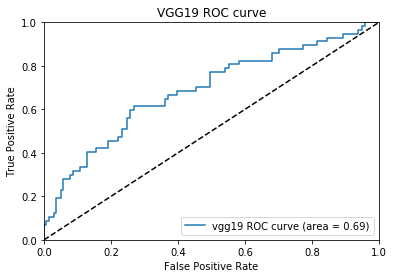

0.557410337324


In [3]:
import pandas as pd
import numpy as np 
import pylab as pl 
from sklearn.metrics import roc_curve, auc
print 'come into file'
df_1 = pd.read_csv('stage1_solution.csv')
df_2 = pd.read_csv('submitvgg19.csv')
merge = df_1.merge(df_2, on = 'id')
print 'merge csv', merge
keep_cols = ['cancer_x', 'cancer_y']
df = merge[keep_cols]
print 'finish reading csv file'
y_test = np.array(df)[:,0]
probas = np.array(df)[:,1]
# print y_test
# print 'probas', probas
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas)
print 'thresholds', thresholds
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

pl.clf()
pl.plot(fpr, tpr, label='vgg19 ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('VGG19 ROC curve')
pl.legend(loc="lower right")
pl.show()

from sklearn import metrics
print (metrics.log_loss(y_test, probas))